In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report


In [17]:
data = pd.read_csv("Bank_churn.csv")

In [18]:
print(data.info())
# Check for missing values in each column
# print(data.isnull())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           10000 non-null  int64  
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  churn            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


Requirements
1. Data Preprocessing & EDA
● Build a generic data preprocessing function capable of handling datasets with varying
features.
● Perform a quick Exploratory Data Analysis (EDA) on at least one dataset to
understand the data structure and key features.
2. Feature Engineering
● Apply generic feature transformations or engineering.
3. Model Selection & Training
● Choose and train appropriate machine learning models (e.g., Random Forest, Logistic
Regression, XGBoost) based on the data's complexity.
4. Model Evaluation
● Evaluate the model using metrics such as Accuracy, Precision, Recall, and AUC-ROC.
5. Backend Development with FastAPI
● Create a FastAPI backend with a prediction endpoint that works with multiple datasets.
● The system should switch between datasets and their respective models through the
API.
6. Explainability with MLI Techniques
● Implement at least three MLI techniques:
○ Global explanations (e.g., PDP, global SHAP).
○ Local explanations (e.g., LIME, local SHAP).

Basic EDA

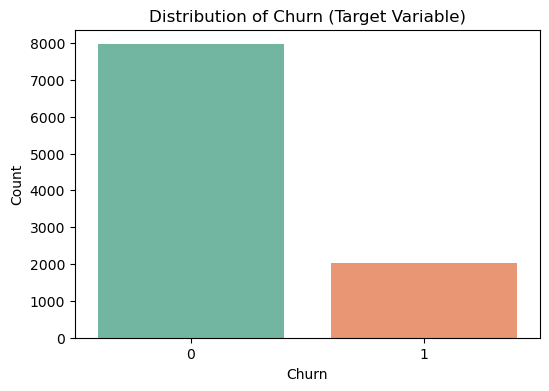

In [19]:
# Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=data, palette='Set2')
plt.title('Distribution of Churn (Target Variable)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

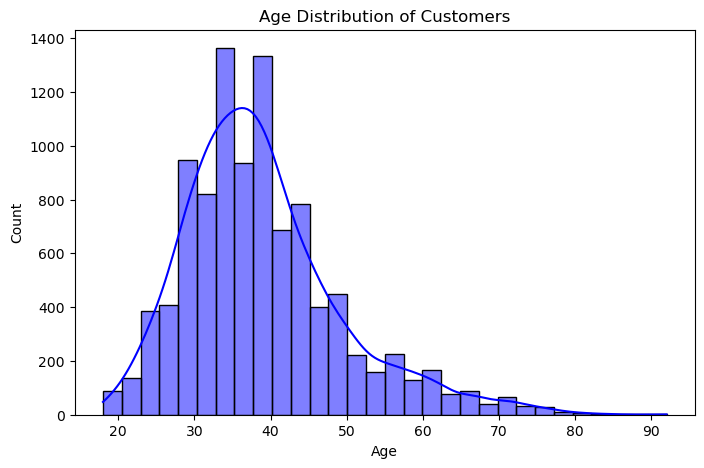

In [20]:
# Age Distribution of Customers
plt.figure(figsize=(8, 5))
sns.histplot(data['age'], kde=True, bins=30, color='blue')
plt.title('Age Distribution of Customers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

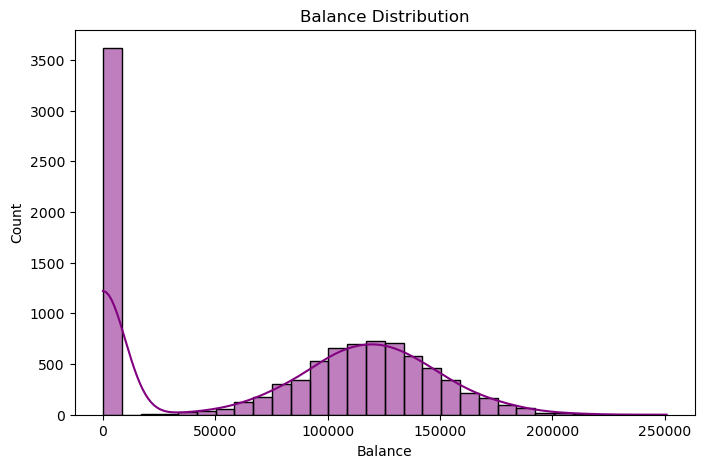

In [21]:
# Balance Distribution
plt.figure(figsize=(8, 5))
sns.histplot(data['balance'], kde=True, bins=30, color='purple')
plt.title('Balance Distribution')
plt.xlabel('Balance')
plt.ylabel('Count')
plt.show()

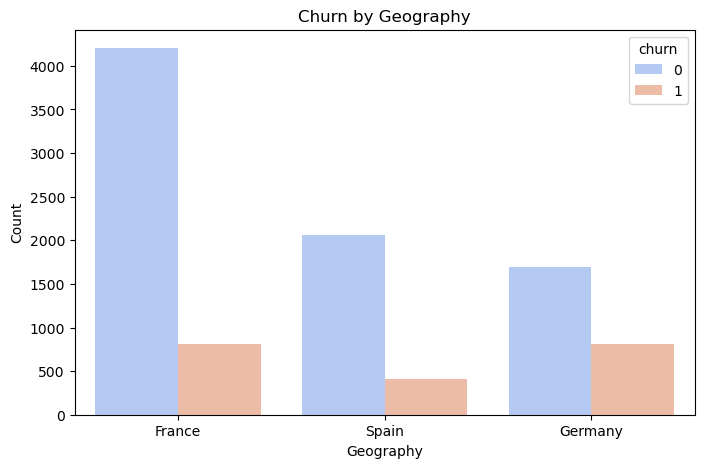

In [22]:
# Churn by Geography
plt.figure(figsize=(8, 5))
sns.countplot(x='geography', hue='churn', data=data, palette='coolwarm')
plt.title('Churn by Geography')
plt.xlabel('Geography')
plt.ylabel('Count')
plt.show()

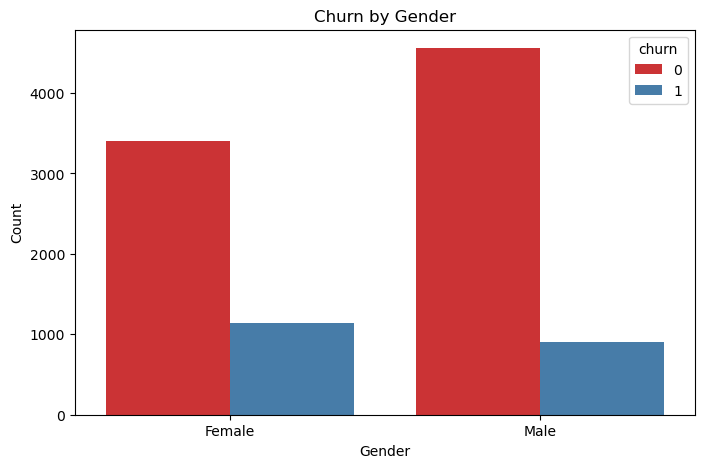

In [23]:
# Churn by Gender
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', hue='churn', data=data, palette='Set1')
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

Feature Engineering

In [24]:
# One-Hot Encoding of categorical variables (gender, geography)
data_encoded = pd.get_dummies(data, columns=['gender', 'geography'], drop_first=True)
# Creating new features
# Age Group
bins = [18, 30, 50, 100]
labels = ['Young', 'Middle-aged', 'Senior']
data_encoded['age_group'] = pd.cut(data_encoded['age'], bins=bins, labels=labels, right=False)

# Balance to Salary Ratio
data_encoded['balance_salary_ratio'] = np.where(data_encoded['estimatedsalary'] != 0,
                                                data_encoded['balance'] / data_encoded['estimatedsalary'], 0)

# Scaling the Features
scaler = StandardScaler()  # Or MinMaxScaler() depending on the use case
numerical_features = ['creditscore', 'age', 'balance', 'estimatedsalary']
data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])

# Handling outliers - Capping the balance and creditscore
data_encoded['balance'] = np.clip(data_encoded['balance'], 0, 250000)  # Capping balance at 250k
data_encoded['creditscore'] = np.clip(data_encoded['creditscore'], 350, 850)  # Capping credit score range

# Interaction Terms
data_encoded['age_product_interaction'] = data_encoded['age'] * data_encoded['numofproducts']

# Display the transformed data
data_encoded.head()


,rownumber,customerid,surname,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,churn,gender_Male,geography_Germany,geography_Spain,age_group,balance_salary_ratio,age_product_interaction
0,1,15634602,Hargrave,350.0,0.293517,2,0.000000,1,1,1,0.021886,1,0,0,0,Middle-aged,0.000000,0.293517
1,2,15647311,Hill,350.0,0.198164,1,0.117350,1,0,1,0.216534,0,0,0,1,Middle-aged,0.744677,0.198164
2,3,15619304,Onio,350.0,0.293517,8,1.333053,3,1,0,0.240687,1,0,0,0,Middle-aged,1.401375,0.880552
3,4,15701354,Boni,350.0,0.007457,1,0.000000,2,0,0,-0.108918,0,0,0,0,Middle-aged,0.000000,0.014913
4,5,15737888,Mitchell,350.0,0.388871,2,0.785728,1,1,1,-0.365276,0,0,0,1,Middle-aged,1.587055,0.388871


# model

In [25]:
# Encoding the 'age_group' using One-Hot Encoding
# One-Hot Encoding for the 'age_group' column
data_encoded = pd.get_dummies(data_encoded, columns=['age_group'], drop_first=True)

# Drop unnecessary columns
X = data_encoded.drop(columns=['churn', 'customerid', 'surname'])  # Target is 'churn'
y = data_encoded['churn']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
# Training the models

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb = XGBClassifier(eval_metric='logloss')
xgb.fit(X_train, y_train)

# Predictions
y_pred_log_reg = log_reg.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)


In [28]:
# Evaluate the models
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(classification_report(y_true, y_pred))
    print("-" * 60)

# Evaluate Logistic Regression
evaluate_model(y_test, y_pred_log_reg, "Logistic Regression")

# Evaluate Random Forest
evaluate_model(y_test, y_pred_rf, "Random Forest")

# Evaluate XGBoost
evaluate_model(y_test, y_pred_xgb, "XGBoost")

Model: Logistic Regression
Accuracy: 0.8163
Precision: 0.5775
Recall: 0.2106
AUC-ROC: 0.5867
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      2416
           1       0.58      0.21      0.31       584

    accuracy                           0.82      3000
   macro avg       0.71      0.59      0.60      3000
weighted avg       0.78      0.82      0.78      3000

------------------------------------------------------------
Model: Random Forest
Accuracy: 0.8667
Precision: 0.7556
Recall: 0.4658
AUC-ROC: 0.7147
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2416
           1       0.76      0.47      0.58       584

    accuracy                           0.87      3000
   macro avg       0.82      0.71      0.75      3000
weighted avg       0.86      0.87      0.85      3000

------------------------------------------------------------
Model: XGBoost
Accuracy: 0.8620
Precision: 0

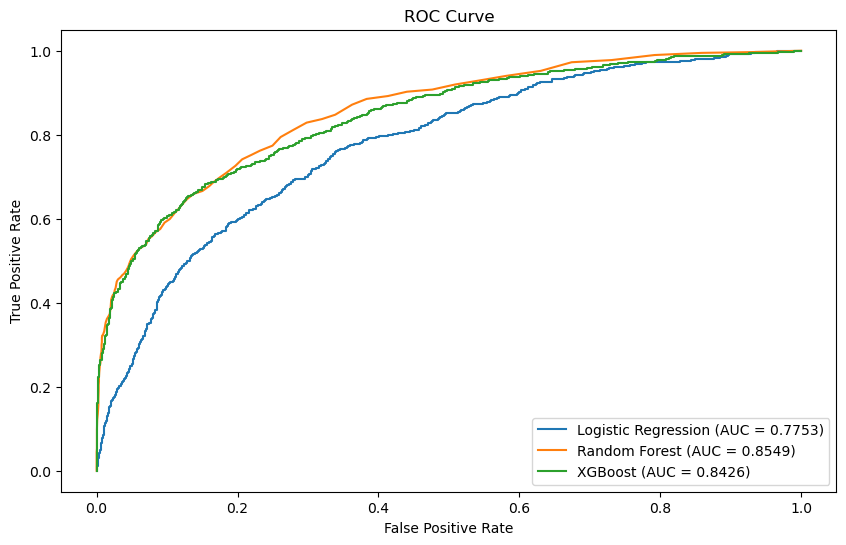

In [29]:

# ROC Curve plotting
def plot_roc_curve(model, X_test, y_test, model_name):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_prob):.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

plt.figure(figsize=(10, 6))
plot_roc_curve(log_reg, X_test, y_test, 'Logistic Regression')
plot_roc_curve(rf, X_test, y_test, 'Random Forest')
plot_roc_curve(xgb, X_test, y_test, 'XGBoost')
plt.show()